In [15]:
import os
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
from shapely import wkt

# Soil Regions

### Type of the soil dataset

This dataset represents different land areas in the Netherlands, categorized by soil types and land use. Each row describes a specific region with attributes such as the name (LMM14naam), soil type (HGRnaam), surface area (Oppkm2 in square kilometers and OppHa in hectares), and geometry (MULTIPOLYGON) used for spatial mapping.

In [4]:
type_of_data = "type_of_soil"

current_dir = os.getcwd()
datasetdir = os.path.join(current_dir, '../../data/raw', type_of_data)
soil_type_path = os.path.join(datasetdir, "LMM14_HGR.shp")

In [5]:
lmm = gpd.read_file(soil_type_path)
print(lmm.columns)
lmm.head()

Index(['LMM14nr', 'LMM14naam', 'HGRnr', 'HGRnaam', 'Oppkm2', 'OppHa', 'groep',
       'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')


,LMM14nr,LMM14naam,HGRnr,HGRnaam,Oppkm2,OppHa,groep,Shape_Leng,Shape_Area,geometry
0,1,Noordelijk Zeekleigebied,2,klei,2782,278155.0,Klei,6.914546e+05,2.781548e+09,"MULTIPOLYGON (((153749 565427, 153793 565364, ..."
1,2,Noordelijk Veenweidegeb.,3,veen,1657,165741.0,Veen,4.736756e+05,1.657414e+09,"MULTIPOLYGON (((184855 511154, 184892 511129, ..."
2,3,Polders en Droogmakerijen,2,klei,3422,342242.0,Klei,1.003352e+06,3.422415e+09,"MULTIPOLYGON (((92170.4 460493.696, 92437.4 46..."
3,4,Westelijk Veenweidegeb.,3,veen,1929,192919.0,Veen,7.014368e+05,1.929187e+09,"MULTIPOLYGON (((147852.2 476898.22, 147938.05 ..."
4,5,Zuidwestelijk Kleigebied,2,klei,3630,363042.0,Klei,1.638755e+06,3.630416e+09,"MULTIPOLYGON (((25134.069 381458.669, 25226.24..."


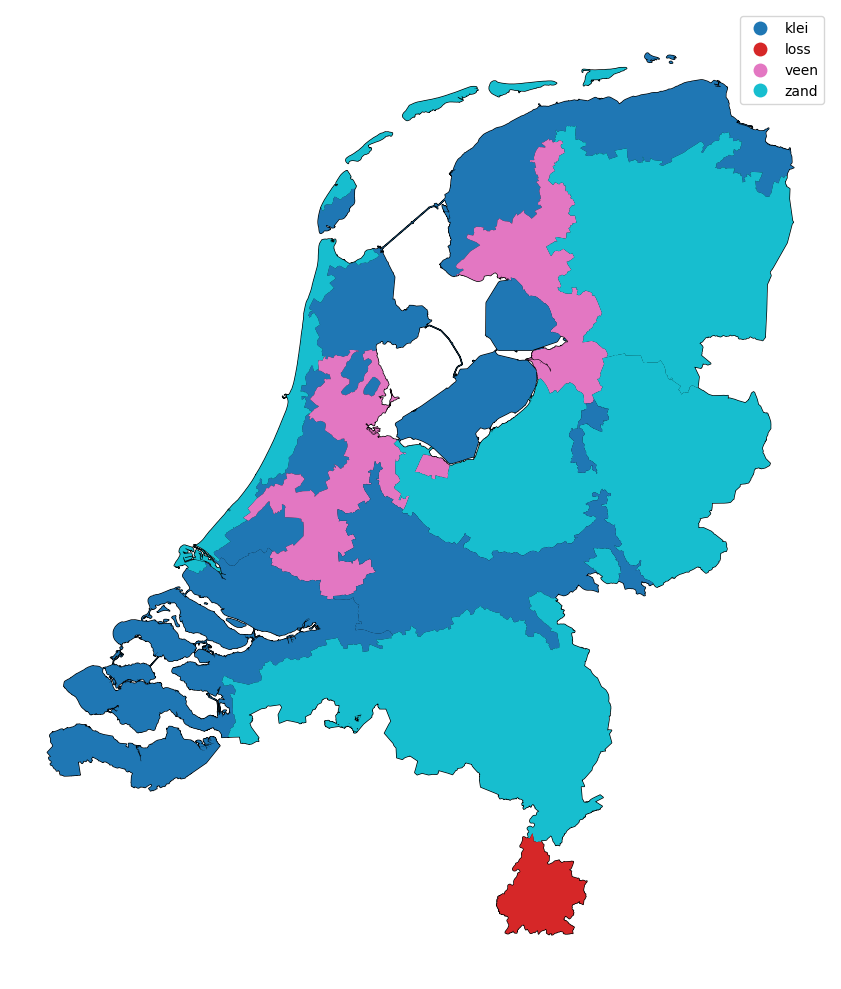

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
lmm.plot(ax=ax, edgecolor='black', facecolor='lightgrey')

lmm.plot(column='HGRnaam', ax=ax, legend=True)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [7]:
def aoi_finder():
    # load Utrecht polygon coordinates
    utrecht_polygon_path = os.path.join(datasetdir, "..", "utrecht polygon.csv")
    df = pd.read_csv(utrecht_polygon_path, sep=';')

    geo_shape_str = df.loc[0, "Geo Shape"] #coordinates of the polygon
    geo_shape = json.loads(geo_shape_str)
    coords = geo_shape["coordinates"][0]  # outer ring of the polygon

    utrecht_polygon = Polygon(coords)

    # define boundary line
    x1, y1 = 5.066884, 52.170366  # upper-left
    x2, y2 = 5.237030, 51.978896  # lower-right

    def is_above_line(x, y):
        """Returns True if point (x, y) is above the diagonal line"""
        if x1 == x2:
            return y > y1  # vertical line
        slope = (y2 - y1) / (x2 - x1)
        y_on_line = slope * (x - x1) + y1
        return (y > y_on_line) and (x > x1)

    # Filter polygon coordinates
    filtered_coords = [
        (x, y) for x, y in utrecht_polygon.exterior.coords
        if is_above_line(x, y)]

    # Make sure polygon closes properly
    if filtered_coords[0] != filtered_coords[-1]:
        filtered_coords.append(filtered_coords[0])

    #new precise polygon
    aoi = Polygon(filtered_coords)

    utrecht_mask = gpd.GeoDataFrame(geometry=[aoi], crs="EPSG:4326")
    return utrecht_mask

In [8]:
utrecht_mask = aoi_finder()
utrecht_mask_rd = utrecht_mask.to_crs(lmm.crs)
cropped_gdf = gpd.overlay(lmm, utrecht_mask_rd, how='intersection')

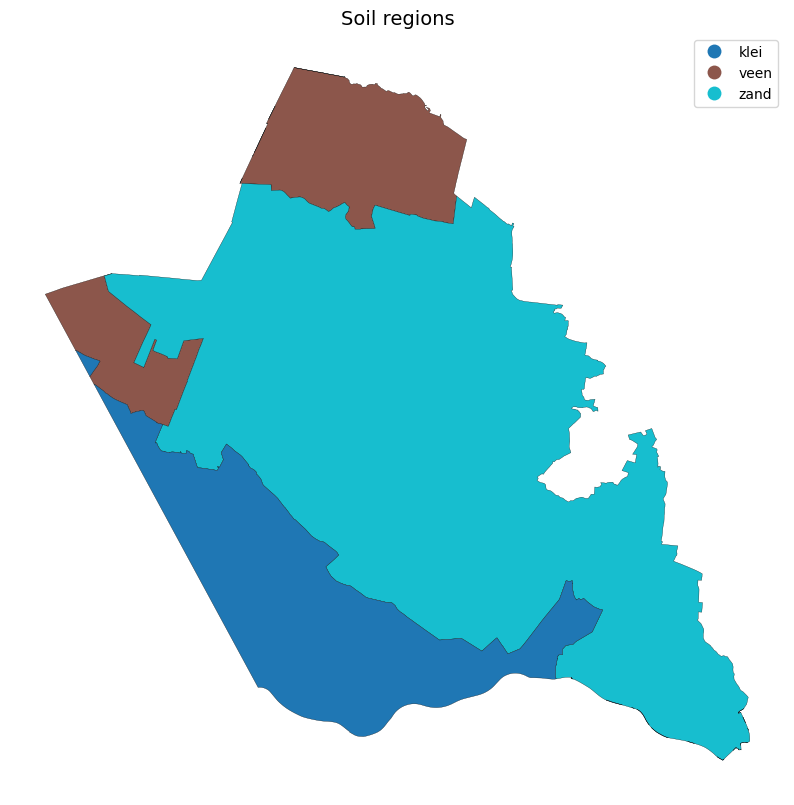

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
cropped_gdf.plot(column="HGRnaam", ax=ax, legend=True, cmap="tab10", edgecolor="black", linewidth=0.2)

ax.set_title("Soil regions", fontsize=14)
ax.set_axis_off()
plt.show()

## Nitrate data

In [34]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/clean/aligned_data', f"merged_dataset_{well_filter}.csv")
df = pd.read_csv(path)
len(df)

192

In [35]:
df["geometry"] = df["geometry"].apply(wkt.loads)

In [36]:
points_gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

In [37]:
points_gdf = points_gdf.to_crs(cropped_gdf.crs)

## Groundwater table data

In [58]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/clean/well_depth_data/for_Alignment', f"utrecht_well_depth_combined_{well_filter}.csv")
depth_df = pd.read_csv(path)
len(depth_df)

177955

In [59]:
depth_df["geometry"] = depth_df["geometry"].apply(wkt.loads)

In [60]:
depth_gdf = gpd.GeoDataFrame(depth_df, geometry="geometry", crs="EPSG:4326")

In [61]:
depth_gdf = depth_gdf.to_crs(cropped_gdf.crs)

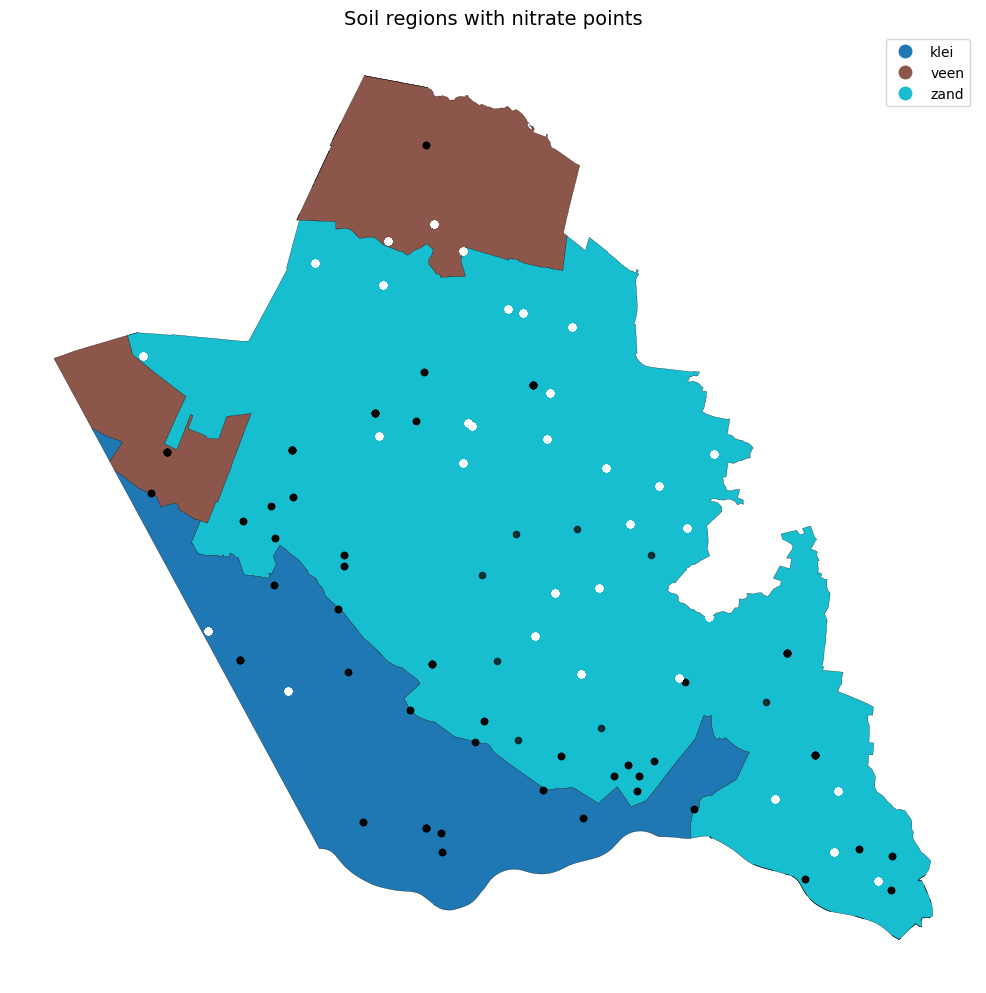

In [62]:
fig, ax = plt.subplots(figsize=(10, 10))

# Background: soil regions
cropped_gdf.plot(column="HGRnaam", ax=ax, legend=True, cmap="tab10", edgecolor="black", linewidth=0.2)

# Overlay: nitrate points
points_gdf.plot(ax=ax, color='black', markersize=20, alpha=0.7)

# Overlay: depth points
depth_gdf.plot(ax=ax, color='white', markersize=20, alpha=0.7)

ax.set_title("Soil regions with nitrate points", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()